In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/FrancescoZanella/RecSysChallenge2024.git

Cloning into 'RecSysChallenge2024'...
remote: Enumerating objects: 3580, done.
remote: Counting objects: 100% (1190/1190), done.
remote: Compressing objects: 100% (484/484), done.
remote: Total 3580 (delta 799), reused 1078 (delta 703), pack-reused 2390
Receiving objects: 100% (3580/3580), 44.13 MiB | 19.63 MiB/s, done.
Resolving deltas: 100% (2294/2294), done.


In [2]:
%cd /kaggle/working/RecSysChallenge2024/src

/kaggle/working/RecSysChallenge2024/src


In [3]:
! pip install --upgrade polars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 56.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: polars
    Found existing installation: polars 0.20.21
    Uninstalling polars-0.20.21:
      Successfully uninstalled polars-0.20.21


In [4]:
! pip install simsimd scikit-learn==1.4.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 78.7 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.2/382.2 kB 21.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import polars as pl
import scipy.stats as stats
import scipy.sparse as sps
import gc
import tqdm

from ebrec.utils._descriptive_analysis import (
    min_max_impression_time_behaviors, 
    min_max_impression_time_history
)
from ebrec.utils._polars import slice_join_dataframes
from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    truncate_history,
)
from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_USER_COL
)
from ebrec.evaluation.metrics_protocols import *

In [6]:
predictions_df = None

paths = {
    'gandalf': '/kaggle/input/gandalf/gandalf_predictions.parquet',
    'mlp': '/kaggle/input/simple-mlp/mlp_predictions.parquet',
    'wide_deep': '/kaggle/input/wide-deep-network/wide_deep_predictions.parquet',
    'deep_cross': '/kaggle/input/deep-cross-network/deep_cross_predictions.parquet',
    'catboost': '/kaggle/input/catboost/wide_deep_predictions.parquet',
    'ranker': '/kaggle/input/catboost-ranker/wide_deep_predictions.parquet',
    'fast_rgf': '/kaggle/input/fastrgf/fast_rgf_predictions.parquet',
    'random_forest': '/kaggle/input/random-forest-lgbm/lgbm_rf_predictions.parquet',
    'logistic_regression': '/kaggle/input/simple-logistic-regression/mlp_predictions.parquet'
}
for model_name, path in tqdm.tqdm(paths.items()):
    
    model_preds = pl.read_parquet(path) \
        .rename({'prediction': f'{model_name}_prediction'}) \
        .with_columns(
            pl.col(f'{model_name}_prediction').min().over('impression_id').alias('min_pred_impression'),
            pl.col(f'{model_name}_prediction').max().over('impression_id').alias('max_pred_impression'),
        ).with_columns(
            (
                (pl.col(f'{model_name}_prediction') - pl.col('min_pred_impression')) /
                (pl.col('max_pred_impression') - pl.col('min_pred_impression'))
            ).alias(f'{model_name}_prediction')
        ).select(['impression_id', 'article', 'target', f'{model_name}_prediction'])
    
    if predictions_df is None:
        predictions_df = model_preds
    else:
        predictions_df = predictions_df.join(model_preds.drop('target'), 
                                             on=['impression_id', 'article'], how='left')
predictions_df.head()

100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


impression_id,article,target,gandalf_prediction,mlp_prediction,wide_deep_prediction,deep_cross_prediction,catboost_prediction,ranker_prediction,fast_rgf_prediction,random_forest_prediction,logistic_regression_prediction
u32,i32,i8,f32,f32,f32,f32,f64,f64,f64,f64,f64
260910155,9765618,0,0.0,0.006764,0.0489,0.111769,0.026035,0.068666,0.0,0.0,0.0
64250494,9766434,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
503100530,9780181,0,0.690996,1.0,0.753337,0.79691,0.750342,0.66713,0.629966,0.579377,0.577927
60288916,9695098,0,0.077381,0.0,0.0,0.045347,0.276834,0.351105,0.318667,0.0,0.0
306096294,9780302,0,0.069384,0.560292,0.736152,0.173966,0.677936,0.748569,0.379602,0.409741,0.900485


<Axes: >

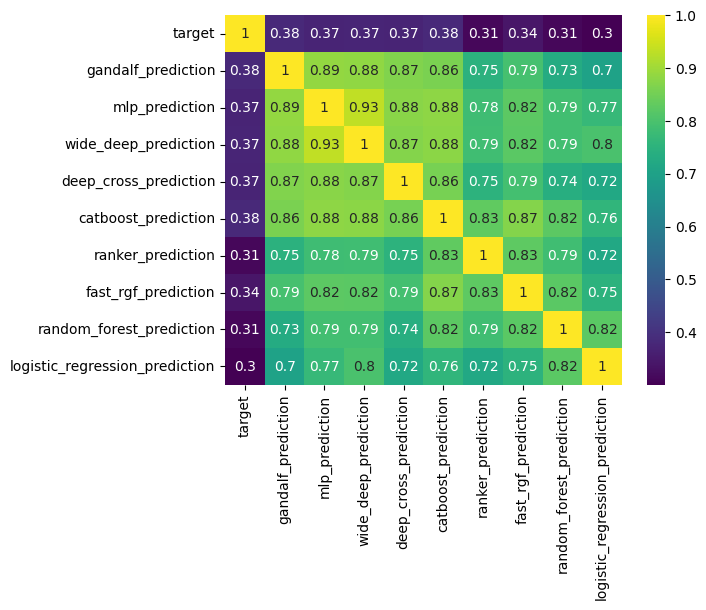

In [7]:
correlations = predictions_df.drop(['impression_id', 'article']).to_pandas().corr()

sns.heatmap(correlations, cmap='viridis', annot=True)

In [8]:
predictions_df = predictions_df.with_columns(
    (0.34 * pl.col('gandalf_prediction') + 0.33 * pl.col('mlp_prediction') + 0.33 * pl.col('wide_deep_prediction')).alias('g_wd_mlp_mean_pred'),
    (0.25 * pl.col('gandalf_prediction') + 0.25 * pl.col('mlp_prediction') + 0.25 * pl.col('wide_deep_prediction') + 0.25 * pl.col('deep_cross_prediction')).alias('neurals_mean_pred'),
    (0.5 * pl.col('gandalf_prediction') + 0.5 * pl.col('mlp_prediction')).alias('gandalf_mlp_pred'),
    (0.5 * pl.col('gandalf_prediction') + 0.5 * pl.col('wide_deep_prediction')).alias('gandalf_wd_pred'),
    (0.5 * pl.col('mlp_prediction') + 0.5 * pl.col('wide_deep_prediction')).alias('mlp_wd_pred'),
    (0.45 * pl.col('gandalf_prediction') + 0.25 * pl.col('mlp_prediction') + 0.3 * pl.col('wide_deep_prediction')).alias('g_wd_mlp_weight_mean_pred'),
    (0.4 * pl.col('gandalf_prediction') + 0.2 * pl.col('mlp_prediction') + 0.25 * pl.col('wide_deep_prediction') + 0.15 * pl.col('deep_cross_prediction')).alias('neurals_weight_mean_pred'),
    (0.5 * pl.col('gandalf_prediction') + 0.5 * pl.col('catboost_prediction')).alias('gandalf_catboost_pred'),
    (0.4 * pl.col('gandalf_prediction') + 0.4 * pl.col('catboost_prediction') + 0.2 * pl.col('fast_rgf_prediction')).alias('gandalf_catboost_rgf_pred'),
    (0.3 * pl.col('gandalf_prediction') + 0.2 * pl.col('mlp_prediction') + 0.2 * pl.col('wide_deep_prediction') + 0.3 * pl.col('catboost_prediction')).alias('catboost_g_wd_mlp_weight_mean_pred'),
    (0.2 * pl.col('gandalf_prediction') + 0.2 * pl.col('mlp_prediction') + 0.2 * pl.col('wide_deep_prediction') + 0.2 * pl.col('catboost_prediction') + 0.2 * pl.col('logistic_regression_prediction')).alias('cb_lr_g_wd_mlp_mean_pred'),
    (0.3 * pl.col('gandalf_prediction') + 0.175 * pl.col('mlp_prediction') + 0.175 * pl.col('wide_deep_prediction') + 0.3 * pl.col('catboost_prediction') + 0.05 * pl.col('logistic_regression_prediction')).alias('cb_lr_g_wd_mlp_weight_mean_pred'),
    (0.2 * pl.col('gandalf_prediction') + 0.2 * pl.col('mlp_prediction') + 0.2 * pl.col('wide_deep_prediction') + 0.2 * pl.col('catboost_prediction') + 0.1 * pl.col('logistic_regression_prediction') + 0.1 * pl.col('random_forest_prediction')).alias('cb_rf_lr_g_wd_mlp_weight_mean_pred'),
    (0.3 * pl.col('gandalf_prediction') + 0.15 * pl.col('mlp_prediction') + 0.15 * pl.col('wide_deep_prediction') + 0.3 * pl.col('catboost_prediction') + 0.05 * pl.col('logistic_regression_prediction') + 0.05 * pl.col('random_forest_prediction')).alias('cb_rf_lr_g_wd_mlp_weight_mean_pred_v2'),
    (0.3 * pl.col('gandalf_prediction') + 0.1 * pl.col('mlp_prediction') + 0.15 * pl.col('wide_deep_prediction') + 0.3 * pl.col('catboost_prediction') + 0.05 * pl.col('deep_cross_prediction') + 0.1 * pl.col('fast_rgf_prediction')).alias('cb_g_wd_mlp_dcn_rgf_weight_mean_pred'),
    (0.25 * pl.col('gandalf_prediction') + 0.1 * pl.col('mlp_prediction') + 0.1 * pl.col('wide_deep_prediction') + 0.25 * pl.col('catboost_prediction') + 0.05 * pl.col('deep_cross_prediction') + 0.25 * pl.col('ranker_prediction')).alias('best_models_weight_mean_pred'),
)
predictions_df.head()

impression_id,article,target,gandalf_prediction,mlp_prediction,wide_deep_prediction,deep_cross_prediction,catboost_prediction,ranker_prediction,fast_rgf_prediction,random_forest_prediction,logistic_regression_prediction,g_wd_mlp_mean_pred,neurals_mean_pred,gandalf_mlp_pred,gandalf_wd_pred,mlp_wd_pred,g_wd_mlp_weight_mean_pred,neurals_weight_mean_pred,gandalf_catboost_pred,gandalf_catboost_rgf_pred,catboost_g_wd_mlp_weight_mean_pred,cb_lr_g_wd_mlp_mean_pred,cb_lr_g_wd_mlp_weight_mean_pred,cb_rf_lr_g_wd_mlp_weight_mean_pred,cb_rf_lr_g_wd_mlp_weight_mean_pred_v2,cb_g_wd_mlp_dcn_rgf_weight_mean_pred,best_models_weight_mean_pred
u32,i32,i8,f32,f32,f32,f32,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64
260910155,9765618,0,0.0,0.006764,0.0489,0.111769,0.026035,0.068666,0.0,0.0,0.0,0.018369,0.041858,0.003382,0.02445,0.027832,0.016361,0.030343,0.013018,0.010414,0.018943,0.01634,0.017552,0.01634,0.01616,0.02141,0.03483
64250494,9766434,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
503100530,9780181,0,0.690996,1.0,0.753337,0.79691,0.750342,0.66713,0.629966,0.579377,0.577927,0.81354,0.810311,0.845498,0.722167,0.876668,0.786949,0.784269,0.720669,0.702528,0.783069,0.75452,0.768132,0.754665,0.753267,0.748244,0.742296
60288916,9695098,0,0.077381,0.0,0.0,0.045347,0.276834,0.351105,0.318667,0.0,0.0,0.026309,0.030682,0.03869,0.03869,0.0,0.034821,0.037754,0.177107,0.205419,0.106264,0.070843,0.106264,0.070843,0.106264,0.140398,0.178597
306096294,9780302,0,0.069384,0.560292,0.736152,0.173966,0.677936,0.748569,0.379602,0.409741,0.900485,0.451417,0.384948,0.314838,0.402768,0.648222,0.392141,0.349945,0.37366,0.374848,0.483485,0.58885,0.496098,0.539775,0.484174,0.437306,0.512315


In [9]:
evaluation_ds = predictions_df.group_by('impression_id').agg(pl.exclude(['article', 'user_id']))
evaluation_ds.head()

impression_id,target,gandalf_prediction,mlp_prediction,wide_deep_prediction,deep_cross_prediction,catboost_prediction,ranker_prediction,fast_rgf_prediction,random_forest_prediction,logistic_regression_prediction,g_wd_mlp_mean_pred,neurals_mean_pred,gandalf_mlp_pred,gandalf_wd_pred,mlp_wd_pred,g_wd_mlp_weight_mean_pred,neurals_weight_mean_pred,gandalf_catboost_pred,gandalf_catboost_rgf_pred,catboost_g_wd_mlp_weight_mean_pred,cb_lr_g_wd_mlp_mean_pred,cb_lr_g_wd_mlp_weight_mean_pred,cb_rf_lr_g_wd_mlp_weight_mean_pred,cb_rf_lr_g_wd_mlp_weight_mean_pred_v2,cb_g_wd_mlp_dcn_rgf_weight_mean_pred,best_models_weight_mean_pred
u32,list[i8],list[f32],list[f32],list[f32],list[f32],list[f64],list[f64],list[f64],list[f64],list[f64],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64],list[f64]
308231247,"[0, 0, … 0]","[0.175908, 0.780075, … 0.0]","[0.172574, 0.796449, … 0.0]","[0.314364, 1.0, … 0.0]","[0.103996, 0.635744, … 0.0]","[0.105687, 0.672149, … 0.0]","[0.255982, 0.873554, … 0.0]","[0.146674, 0.829353, … 0.0]","[0.218773, 0.699017, … 0.0]","[0.102928, 0.587679, … 0.0]","[0.220498, 0.858054, … 0.0]","[0.191711, 0.803067, … 0.0]","[0.174241, 0.788262, … 0.0]","[0.245136, 0.890038, … 0.0]","[0.243469, 0.898225, … 0.0]","[0.216611, 0.850146, … 0.0]","[0.199069, 0.816681, … 0.0]","[0.140798, 0.726112, … 0.0]","[0.141973, 0.74676, … 0.0]","[0.181866, 0.794957, … 0.0]","[0.174292, 0.767271, … 0.0]","[0.174839, 0.77943, … 0.0]","[0.185877, 0.778404, … 0.0]","[0.173604, 0.769469, … 0.0]","[0.168758, 0.780035, … 0.0]","[0.188288, 0.792877, … 0.0]"
357800134,"[0, 0, … 0]","[0.001541, 0.000843, … 0.000026]","[0.007729, 0.0, … 0.004433]","[0.006416, 0.00306, … 0.008616]","[0.001882, 0.0, … 0.000428]","[0.001651, 0.002881, … 0.0057]","[0.072385, 0.124013, … 0.025243]","[0.030889, 0.0, … 0.008359]","[0.002171, 0.001998, … 0.0]","[0.0, 0.02382, … 0.191323]","[0.005192, 0.001296, … 0.004315]","[0.004392, 0.000976, … 0.003376]","[0.004635, 0.000421, … 0.00223]","[0.003978, 0.001951, … 0.004321]","[0.007072, 0.00153, … 0.006525]","[0.00455, 0.001297, … 0.003705]","[0.004048, 0.001102, … 0.003115]","[0.001596, 0.001862, … 0.002863]","[0.007454, 0.001489, … 0.003962]","[0.003786, 0.001729, … 0.004328]","[0.003467, 0.006121, … 0.04202]","[0.003433, 0.002843, … 0.013568]","[0.003684, 0.003938, … 0.022887]","[0.003188, 0.002867, … 0.013241]","[0.005876, 0.001576, … 0.004311]","[0.020403, 0.03224, … 0.009069]"
77984607,"[0, 0, … 0]","[0.079607, 0.888739, … 0.014313]","[0.024256, 1.0, … 0.014148]","[0.020014, 0.89342, … 0.024254]","[0.058765, 0.976979, … 0.009748]","[0.033806, 0.984479, … 0.014595]","[0.361947, 1.0, … 0.081495]","[0.356578, 0.907473, … 0.078583]","[0.133593, 1.0, … 0.01781]","[0.21574, 1.0, … 0.28179]","[0.041676, 0.927, … 0.017539]","[0.045661, 0.939784, … 0.015616]","[0.051932, 0.94437, … 0.014231]","[0.04981, 0.891079, … 0.019284]","[0.022135, 0.94671, … 0.019201]","[0.047891, 0.917958, … 0.017254]","[0.050512, 0.925397, … 0.016081]","[0.056706, 0.936609, … 0.014454]","[0.116681, 0.930782, … 0.02728]","[0.042878, 0.940649, … 0.016353]","[0.074685, 0.953328, … 0.06982]","[0.052558, 0.943314, … 0.029482]","[0.06647, 0.953328, … 0.043422]","[0.058131, 0.945978, … 0.029413]","[0.078048, 0.935575, … 0.022071]","[0.126205, 0.956496, … 0.031928]"
531608673,"[0, 0, … 1]","[0.069962, 0.545038, … 1.0]","[0.63616, 0.573098, … 1.0]","[0.465782, 0.53183, … 1.0]","[0.454674, 0.468614, … 1.0]","[0.495111, 0.436888, … 1.0]","[0.715112, 0.74894, … 1.0]","[0.385367, 0.408616, … 1.0]","[0.553836, 0.559667, … 1.0]","[0.395547, 0.705064, … 1.0]","[0.387428, 0.549939, … 1.0]","[0.406645, 0.529645, … 1.0]","[0.353061, 0.559068, … 1.0]","[0.267872, 0.538434, … 1.0]","[0.550971, 0.552464, … 1.0]","[0.330258, 0.548091, … 1.0]","[0.339864, 0.535884, … 1.0]","[0.282537, 0.490963, … 1.0]","[0.303103, 0.474494, … 1.0]","[0.389911, 0.515563, … 1.0]","[0.412513, 0.558384, … 1

In [10]:
met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['gandalf_mlp_pred'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

<MetricEvaluator class>: 
 {
    "auc": 0.811002787939785,
    "mrr": 0.5969377601777506,
    "ndcg@5": 0.6637936127209146,
    "ndcg@10": 0.6880577307994328
}

In [11]:
met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['gandalf_wd_pred'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

<MetricEvaluator class>: 
 {
    "auc": 0.8109363465977162,
    "mrr": 0.5987508547591605,
    "ndcg@5": 0.6655132969042327,
    "ndcg@10": 0.6894747709756147
}

In [12]:
met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['mlp_wd_pred'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

<MetricEvaluator class>: 
 {
    "auc": 0.8066642623201273,
    "mrr": 0.5918303518892792,
    "ndcg@5": 0.6586686052058905,
    "ndcg@10": 0.6835934392489659
}

In [13]:
met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['g_wd_mlp_mean_pred'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

<MetricEvaluator class>: 
 {
    "auc": 0.8114565406185739,
    "mrr": 0.5981686120296353,
    "ndcg@5": 0.6650322107088504,
    "ndcg@10": 0.6889761101903463
}

In [14]:
met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['g_wd_mlp_weight_mean_pred'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

<MetricEvaluator class>: 
 {
    "auc": 0.8118223457995415,
    "mrr": 0.5989196244671354,
    "ndcg@5": 0.6657158822217952,
    "ndcg@10": 0.6896660069239889
}

In [15]:
met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['neurals_mean_pred'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

<MetricEvaluator class>: 
 {
    "auc": 0.8119388519044669,
    "mrr": 0.5988348055872872,
    "ndcg@5": 0.6657034024770007,
    "ndcg@10": 0.6893196422303282
}

In [16]:
met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['neurals_weight_mean_pred'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

<MetricEvaluator class>: 
 {
    "auc": 0.812396162043773,
    "mrr": 0.5998507276530878,
    "ndcg@5": 0.666601951044311,
    "ndcg@10": 0.6902995849002311
}

In [17]:
met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['gandalf_catboost_pred'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

<MetricEvaluator class>: 
 {
    "auc": 0.813053654783314,
    "mrr": 0.6027521188541027,
    "ndcg@5": 0.6688948411185882,
    "ndcg@10": 0.6925786527176808
}

In [18]:
met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['gandalf_catboost_rgf_pred'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

<MetricEvaluator class>: 
 {
    "auc": 0.8126182613882974,
    "mrr": 0.6026149985120519,
    "ndcg@5": 0.6687836994137338,
    "ndcg@10": 0.692247989796688
}

In [19]:
met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['catboost_g_wd_mlp_weight_mean_pred'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

<MetricEvaluator class>: 
 {
    "auc": 0.8142076545261032,
    "mrr": 0.6032914908941767,
    "ndcg@5": 0.6697264209557354,
    "ndcg@10": 0.6930569619997007
}

In [20]:
met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['cb_lr_g_wd_mlp_mean_pred'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

<MetricEvaluator class>: 
 {
    "auc": 0.8094807900764184,
    "mrr": 0.5989144440443492,
    "ndcg@5": 0.665109728769362,
    "ndcg@10": 0.6889525056490234
}

In [21]:
met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['cb_lr_g_wd_mlp_weight_mean_pred'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

<MetricEvaluator class>: 
 {
    "auc": 0.8135793035012168,
    "mrr": 0.6029180109979252,
    "ndcg@5": 0.6693536131015324,
    "ndcg@10": 0.6926552222910178
}

In [22]:
met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['cb_rf_lr_g_wd_mlp_weight_mean_pred'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

<MetricEvaluator class>: 
 {
    "auc": 0.8102706536108402,
    "mrr": 0.5997279916936975,
    "ndcg@5": 0.6659339044987588,
    "ndcg@10": 0.6896501833703981
}

In [23]:
met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['cb_rf_lr_g_wd_mlp_weight_mean_pred_v2'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

<MetricEvaluator class>: 
 {
    "auc": 0.8129162276854133,
    "mrr": 0.602649670758665,
    "ndcg@5": 0.6689141239945744,
    "ndcg@10": 0.6923256277214664
}

In [24]:
met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['cb_g_wd_mlp_dcn_rgf_weight_mean_pred'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

<MetricEvaluator class>: 
 {
    "auc": 0.8143860997948859,
    "mrr": 0.6041901951064933,
    "ndcg@5": 0.670399558314793,
    "ndcg@10": 0.6936141347703332
}

In [25]:
met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['best_models_weight_mean_pred'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

<MetricEvaluator class>: 
 {
    "auc": 0.8163984738243236,
    "mrr": 0.607236147818598,
    "ndcg@5": 0.6734193876675736,
    "ndcg@10": 0.6961418830264577
}